In [1]:
import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from keras.preprocessing import image, image_dataset_from_directory
from keras.models import Sequential, Model
from keras.optimizers import Adam
from focal_loss import BinaryFocalLoss
from keras.layers import Dense, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import classification_report, confusion_matrix
from focal_loss import BinaryFocalLoss
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
import pandas as pd
import os

In [2]:
data=pd.read_csv('/home/jupyter-zaiman/data/DataCenter/CheXpert-v1.0/train.csv')
data = data.filter(["Path", "No Finding"], axis=1)
data = data.fillna(0)
print("Before Undersampling...")
abnormal, normal = data["No Finding"].value_counts()
print("Abnormal: " + str(abnormal))
print("Normal: " + str(normal))
# Divide by class 0 = abnormal , 1 = nomral
df_class_0 = data[data['No Finding'] == 0]
df_class_0 = df_class_0.replace(0, 1)
df_class_1 = data[data['No Finding'] == 1]
df_class_1 = df_class_1.replace(1, 0)
#abnormal = 1, normal = 0
df_class_0_under = df_class_0.sample(normal, random_state=3)
data = pd.concat([df_class_0_under, df_class_1], axis=0)
data["No Finding"] = data["No Finding"].astype(str)
print('After Undersampling:')
print(data["No Finding"].value_counts())
data.head(30000)

Before Undersampling...
Abnormal: 201033
Normal: 22381
After Undersampling:
1.0    22381
0.0    22381
Name: No Finding, dtype: int64


,Path,No Finding
147290,CheXpert-v1.0/train/patient35099/study44/view1...,1.0
9324,CheXpert-v1.0/train/patient02316/study2/view1_...,1.0
164765,CheXpert-v1.0/train/patient38430/study5/view1_...,1.0
161582,CheXpert-v1.0/train/patient37750/study2/view1_...,1.0
17374,CheXpert-v1.0/train/patient04338/study4/view1_...,1.0
...,...,...
66071,CheXpert-v1.0/train/patient15893/study1/view2_...,0.0
66089,CheXpert-v1.0/train/patient15898/study1/view1_...,0.0
66090,CheXpert-v1.0/train/patient15898/study1/view2_...,0.0
66102,CheXpert-v1.0/train/patient15903/study1/view1_...,0.0


In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.4, random_state=1)
valid, test = train_test_split(test, test_size=.5, random_state=1)


In [4]:
#central crop on 224 x 224
IMAGE_WIDTH, IMAGE_HEIGHT = (224, 224)
EPOCHS = 50
BATCH_SIZE = 128
learning = 0.001
image_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

In [5]:
#zero mean to resize -1 to 1 
train_datagen = ImageDataGenerator(
        rescale=1./255,
    )
valid_datagen = ImageDataGenerator(
        rescale=1./255
    )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train, 
    directory='/home/jupyter-zaiman/data/DataCenter/',
    x_col="Path", y_col="No Finding", 
    class_mode="binary", 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size=BATCH_SIZE)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=valid, directory='/home/jupyter-zaiman/data/DataCenter/', x_col="Path", y_col="No Finding", class_mode="binary", target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), shuffle = True, batch_size=BATCH_SIZE)
test_generator=valid_datagen.flow_from_dataframe(dataframe=test, directory='/home/jupyter-zaiman/data/DataCenter/', x_col="Path", y_col="No Finding", class_mode="binary", target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), shuffle = False, batch_size=BATCH_SIZE)

Found 26857 validated image filenames belonging to 2 classes.
Found 8952 validated image filenames belonging to 2 classes.
Found 8953 validated image filenames belonging to 2 classes.


In [6]:
#create model
base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    pooling='max',
)
   
for layer in base.layers:
    layer.trainable = False
    
for layer in [l for l in base.layers if 'conv5' in l.name]:
    layer.trainable = True

x = base.output
x = Dense(512, activation = 'relu')(x)
prediction = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base.input, outputs=prediction)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [7]:
model.compile(optimizer=Adam(lr=learning), loss='binary_crossentropy', metrics=['accuracy'])

save = ModelCheckpoint(
    '/home/jupyter-zaiman/COVID-19 Classification/ResNet50-UnderSampling/', 
    monitor='val_accuracy', 
    save_best_only=True,
    save_weights_only=True, 
    mode='max',
    verbose=1
)
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.01,
    patience=3,
    verbose=1
    )
logger = CSVLogger('/home/jupyter-zaiman/COVID-19 Classification/ResNet50-UnderSampling/training.log')
history = model.fit(train_generator, 
    epochs=EPOCHS, 
    validation_data=valid_generator, 
    verbose=1, 
    callbacks=[save, scheduler, stop, logger]
)
model.save('ResNet50_Undersampling.h5')


Epoch 1/50
210/210 [==============================] - ETA: 0s - loss: 1.5549 - accuracy: 0.5471 
Epoch 00001: val_accuracy improved from -inf to 0.49296, saving model to /home/jupyter-zaiman/COVID-19 Classification/ResNet50-UnderSampling/
210/210 [==============================] - 4330s 21s/step - loss: 1.5549 - accuracy: 0.5471 - val_loss: 0.9575 - val_accuracy: 0.4930
Epoch 2/50
210/210 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.6775 
Epoch 00002: val_accuracy improved from 0.49296 to 0.58177, saving model to /home/jupyter-zaiman/COVID-19 Classification/ResNet50-UnderSampling/
210/210 [==============================] - 3586s 17s/step - loss: 0.6248 - accuracy: 0.6775 - val_loss: 0.8448 - val_accuracy: 0.5818
Epoch 3/50
210/210 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.7060 
Epoch 00003: val_accuracy improved from 0.58177 to 0.68130, saving model to /home/jupyter-zaiman/COVID-19 Classification/ResNet50-UnderSampling/
210/210 [

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


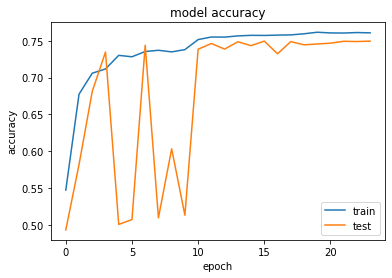

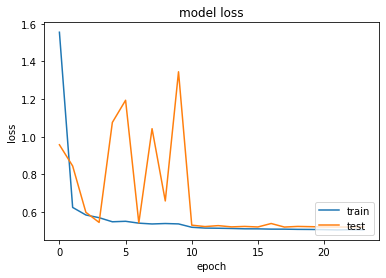

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Normal       0.74      0.76      0.75      4483
    Abnormal       0.75      0.73      0.74      4470

    accuracy                           0.74      8953
   macro avg       0.74      0.74      0.74      8953
weighted avg       0.74      0.74      0.74      8953



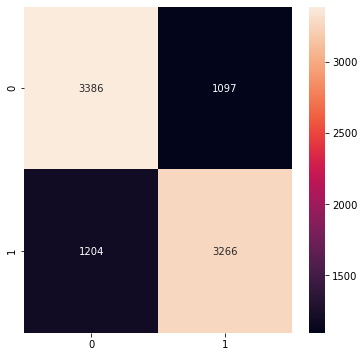

In [9]:
import seaborn as sns
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
    
Y_pred = model.predict(test_generator, len(test_generator.filenames)) 
labels = (Y_pred >= 0.5).astype(np.int)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d");
target_names = ['Normal', 'Abnormal']
print('Classification Report')
print(classification_report(test_generator.classes, labels, target_names=target_names)) 

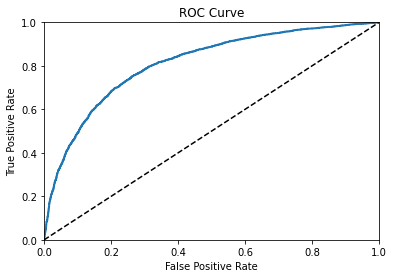

In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_generator.classes, Y_pred)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [11]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_generator.classes, labels)
print(auc)

0.7429732806161582


In [ ]:
test["Predictions"] = labels[:]

In [ ]:
test.head(5)


In [ ]:
misclassified = pd.DataFrame(columns=["Path", "Misclassification"])
paths = []
miss = []

for ind, row in test.iterrows():
    i = row["No Finding"]
    j = row["Predictions"]
    k = row["Path"]
    if i == "0.0" and j == 1:
        paths.append(k)
        miss.append("FN")
    if i == "1.0" and j == 0:
        paths.append(k)
        miss.append("FP")
misclassified["Path"] = paths
misclassified["Misclassification"] = miss
misclassified.shape      

In [ ]:
base_path = '/home/jupyter-zaiman/data/DataCenter/'
import matplotlib.image as mpimg
image1 = mpimg.imread(base_path+arr[0][0])
image2 = mpimg.imread(base_path+arr[1][0])
plt.imshow(image1)

In [ ]:
image2 = mpimg.imread(base_path+arr[1][0])
plt.imshow(image2)

In [ ]:
data1 = pd.read_csv('/home/jupyter-zaiman/data/DataCenter/CheXpert-v1.0/train.csv')
analysis = pd.merge(data1, misclassified, how = "inner", indicator=True)
analysis.shape


In [ ]:
analysis = analysis.drop("_merge", axis=1)
analysis.to_csv("/home/jupyter-zaiman/COVID-19 Classification/ResNet50-UnderSampling/missclassification_data.csv")

In [ ]:
analysis.head()

In [ ]:
for i in analysis:
    analysis[i] = analysis[i].fillna(0)
    analysis[i] = analysis[i].replace(-1, 1)

In [ ]:
analysis.head(50)

In [ ]:
print(analysis["Frontal/Lateral"].value_counts())
print(analysis["AP/PA"].value_counts())
    

In [ ]:
data=pd.read_csv('/home/jupyter-zaiman/data/DataCenter/CheXpert-v1.0/train.csv')
data = data.filter(["Path", "No Finding", "Frontal/Lateral", "AP/PA"], axis=1)
data = data.fillna(0)
print("Before Undersampling...")
abnormal, normal = data["No Finding"].value_counts()
print("Abnormal: " + str(abnormal))
print("Normal: " + str(normal))
# Divide by class
df_class_0 = data[data['No Finding'] == 0]
df_class_1 = data[data['No Finding'] == 1]
df_class_0_under = df_class_0.sample(normal, random_state=3)
data = pd.concat([df_class_0_under, df_class_1], axis=0)
data["No Finding"] = data["No Finding"].astype(str)
print('After Undersampling:')
print(data["No Finding"].value_counts())
train, test = train_test_split(data, test_size=0.4, random_state=1)
valid, test = train_test_split(test, test_size=.5, random_state=1)

In [ ]:
print(test["Frontal/Lateral"].value_counts())
print(test["AP/PA"].value_counts())

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
o = OrdinalEncoder()
analysis["Misclassification"] = o.fit_transform(analysis[["Misclassification"]])
analysis.head()

In [ ]:
#FN = 0, FP = 1
FN = analysis[analysis["Misclassification"] == 0]
FP = analysis[analysis["Misclassification"] == 1]


In [ ]:
print(FN["Frontal/Lateral"].value_counts())
print(FN["AP/PA"].value_counts())

In [ ]:
print(FP["Frontal/Lateral"].value_counts())
print(FP["AP/PA"].value_counts())